In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%pip install numpy==1.24.4

In [2]:
%pip install scikit-surprise

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2463296 sha256=6ba56e182cc036ab41f41b92731309cb8f8368aca9e52e21d287c564d65ee860
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)

In [4]:
ratings = pd.read_csv('/content/drive/My Drive/Datasets/ratings.csv')
movies = pd.read_csv('/content/drive/My Drive/Datasets/movies.csv')

ratings.drop_duplicates(subset=['userId', 'movieId'], inplace=True)
ratings = ratings.drop('timestamp', axis=1)

In [5]:
print("Ratings Count:")
print(ratings.count())
print("\nMovies Count:")
print(movies.count())

Ratings Count:
userId     25000095
movieId    25000095
rating     25000095
dtype: int64

Movies Count:
movieId    62423
title      62423
genres     62423
dtype: int64


In [6]:
print("Ratings Data:")
print(ratings.head(5))
print("\nMovies Data:")
print(movies.head(5))

Ratings Data:
   userId  movieId  rating
0       1      296     5.0
1       1      306     3.5
2       1      307     5.0
3       1      665     5.0
4       1      899     3.5

Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [7]:
print("\nMissing values in ratings:", ratings.isnull().sum())
print("Missing values in movies:", movies.isnull().sum())


Missing values in ratings: userId     0
movieId    0
rating     0
dtype: int64
Missing values in movies: movieId    0
title      0
genres     0
dtype: int64


In [8]:

min_user_ratings = 10
min_movie_ratings = 10

filter_users = ratings['userId'].value_counts() >= min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

filter_movies = ratings['movieId'].value_counts() >= min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

print(f"Before filtering: {ratings['userId'].nunique()} users, "
      f"{ratings['movieId'].nunique()} movies, {len(ratings)} ratings")


ratings = ratings[
    (ratings['userId'].isin(filter_users)) &
    (ratings['movieId'].isin(filter_movies))
].sample(n=20_000_000, random_state=42).reset_index(drop=True)

print(f"\nAfter filtering: {ratings['userId'].nunique()} users, "
      f"{ratings['movieId'].nunique()} movies, {len(ratings)} ratings")

valid_movie_ids = ratings['movieId'].unique()
movies = movies[movies['movieId'].isin(valid_movie_ids)]

Before filtering: 162541 users, 59047 movies, 25000095 ratings

After filtering: 162541 users, 24330 movies, 20000000 ratings


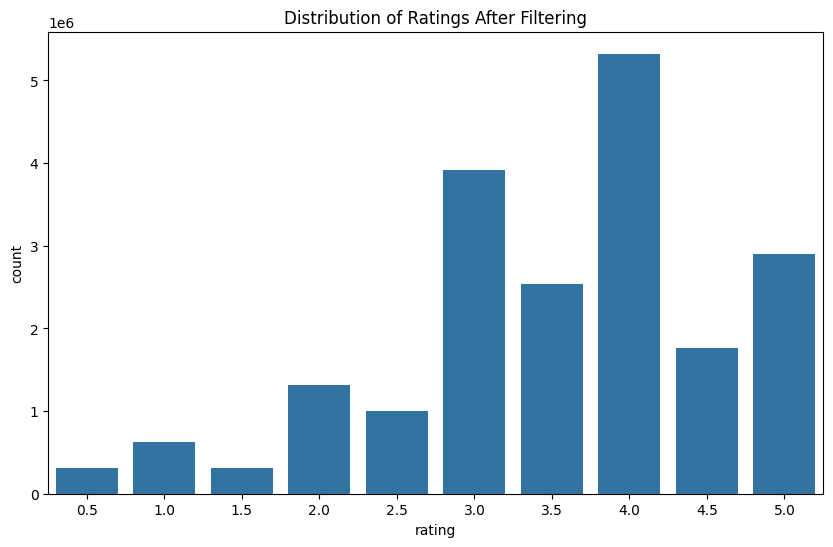

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings After Filtering')
plt.show()

In [10]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [11]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [12]:
# param_grid = {
#     'n_factors':    [50, 100, 150],
#     'n_epochs':     [20, 50],
#     'lr_all':       [0.005, 0.007],
#     'reg_all':      [0.02, 0.05]
# }

# gs = RandomizedSearchCV(
#     SVDpp, param_grid, n_iter=16,
#     measures=['rmse','mae'],
#     cv=2,
#     n_jobs=-1, random_state=42
# )
# gs.fit(data)

# best_params = gs.best_params['rmse']
# print("Best params:", best_params)

class SVDWithHistory(SVD):
    def fit(self, trainset):
        super().fit(trainset)
        self.train_losses = []
        for epoch in range(self.n_epochs):
            loss = 0
            for uid, iid, true_r in trainset.all_ratings():
                est = self.predict(uid, iid, verbose=False).est
                loss += (true_r - est) ** 2
            self.train_losses.append(loss / trainset.n_ratings)
        return self

model = SVDWithHistory(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
model.fit(trainset)

predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"SVD → RMSE: {rmse:.4f}, MAE: {mae:.4f}")

RMSE: 0.7893
MAE:  0.5958
SVD → RMSE: 0.7893, MAE: 0.5958


In [13]:
threshold = 4.0
y_true = np.array([1 if pred.r_ui >= threshold else 0 for pred in predictions])
y_pred = np.array([1 if pred.est  >= threshold else 0 for pred in predictions])
y_score = np.array([pred.est for pred in predictions])

precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
auc       = roc_auc_score(y_true, y_score)

print("Classification Metrics:")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1-Score:  {f1:.4f}")
print(f" AUC-ROC:   {auc:.4f}")

Classification Metrics:
 Precision: 0.8462
 Recall:    0.4778
 F1-Score:  0.6108
 AUC-ROC:   0.8267


<ipython-input-14-1882a0fad1d3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


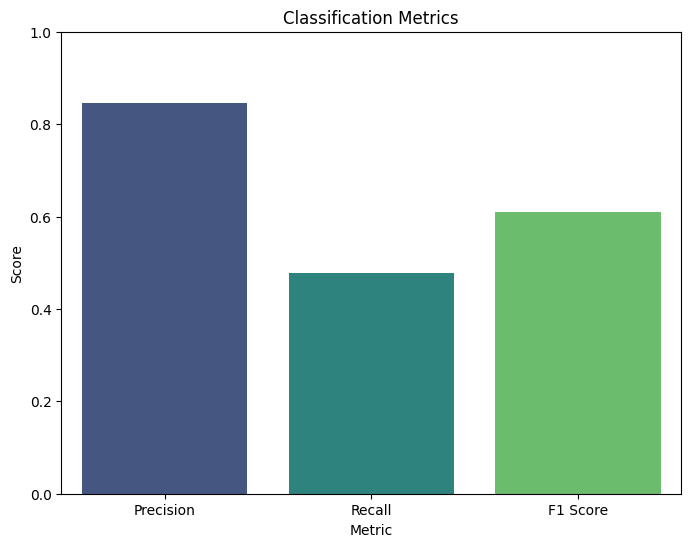

In [14]:
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1]

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.ylim(0, 1)
plt.title('Classification Metrics')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.show()


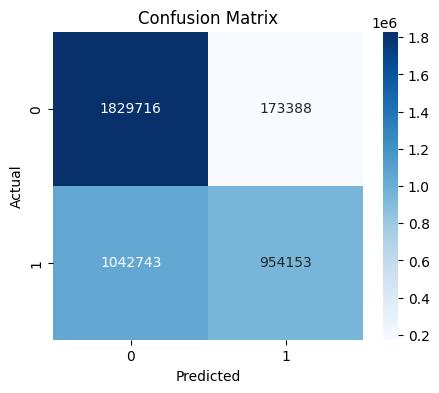

In [15]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

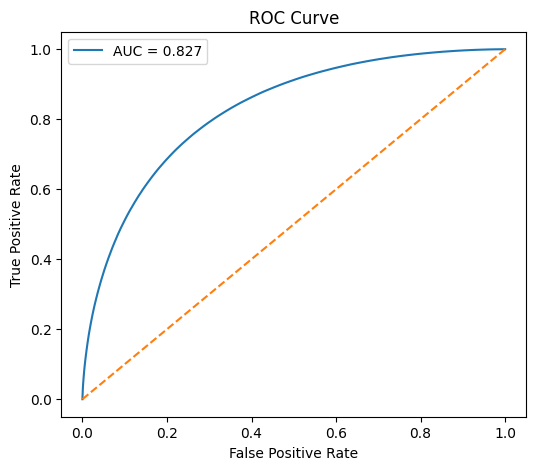

In [16]:
fpr, tpr, _ = roc_curve(y_true, y_score)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [17]:
def get_similar_users(user_id, model, n=5):
    try:
        user_inner_id = model.trainset.to_inner_uid(user_id)
    except ValueError:
        return []

    user_factor = model.pu[user_inner_id]
    all_user_factors = model.pu

    similarities = cosine_similarity([user_factor], all_user_factors)[0]
    sorted_indices = np.argsort(similarities)[::-1][1:n+1]

    return [(model.trainset.to_raw_uid(i), similarities[i])
            for i in sorted_indices]

In [18]:
similar_users = get_similar_users(7046, model)
print("\nUsers similar to User 7046:")
for user_id, similarity in similar_users:
    print(f"User {user_id} with similarity {similarity:.3f}")



Users similar to User 7046:
User 48665 with similarity 0.451
User 80590 with similarity 0.427
User 44542 with similarity 0.423
User 79385 with similarity 0.417
User 34790 with similarity 0.412


In [19]:
def get_top_recommendations(user_id, model, movies_df, n=10):
    all_movie_ids = ratings['movieId'].unique()

    user_rated_movies = ratings[ratings['userId'] == user_id]['movieId']

    unseen_movies = [movie for movie in all_movie_ids if movie not in user_rated_movies.values]

    testset = [[user_id, movie_id, 0.] for movie_id in unseen_movies]
    predictions = model.test(testset)

    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    top_movie_ids = [pred.iid for pred in top_predictions]
    top_ratings = [pred.est for pred in top_predictions]
    recommended_movies = movies_df[movies_df['movieId'].isin(top_movie_ids)]
    recommended_movies = recommended_movies.copy()
    recommended_movies['estimated_rating'] = top_ratings

    return recommended_movies.sort_values('estimated_rating', ascending=False)


In [20]:
user_id = 7046
user_recommendations = get_top_recommendations(user_id, model, movies)
print(f"\nTop 10 Recommendations for User {user_id}:")
print(user_recommendations[['title', 'genres', 'estimated_rating']])


def calculate_metrics(predictions):
    """Calculate RMSE and MAE metrics"""
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])

    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)

    return rmse, mae


Top 10 Recommendations for User 7046:
                                                   title  \
33                                           Babe (1995)   
729               Wallace & Gromit: A Close Shave (1995)   
1167                          Princess Bride, The (1987)   
7028   Lord of the Rings: The Return of the King, The...   
7400                          Pride and Prejudice (1995)   
17101             Turin Horse, The (A Torinói ló) (2011)   
40597                                Planet Earth (2006)   
44566                        Call Me by Your Name (2017)   
45741                             Planet Earth II (2016)   
51245                        Cosmos: A Spacetime Odissey   

                                        genres  estimated_rating  
33                              Children|Drama          5.000000  
729                  Animation|Children|Comedy          5.000000  
1167   Action|Adventure|Comedy|Fantasy|Romance          5.000000  
7028            Action|Adventure


Final Model Metrics:
RMSE: 0.7893
MAE: 0.5958


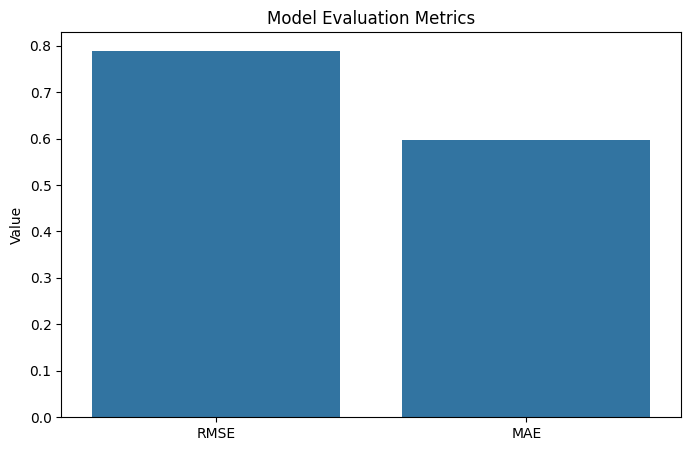

In [21]:
rmse, mae = calculate_metrics(predictions)
print(f"\nFinal Model Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

metrics = ['RMSE', 'MAE']
values = [rmse, mae]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values)
plt.title('Model Evaluation Metrics')
plt.ylabel('Value')
plt.show()

In [22]:
all_movie_ids = ratings['movieId'].unique()
n_movies = len(all_movie_ids)
n_recommended = len(user_recommendations)
coverage = n_recommended / n_movies * 100

print(f"\nCatalog Coverage: {coverage:.2f}% of total movies")
print(f"Number of Unique Movies: {n_movies}")
print(f"Number of Recommended Movies: {n_recommended}")


Catalog Coverage: 0.04% of total movies
Number of Unique Movies: 24330
Number of Recommended Movies: 10
